<a href="https://www.kaggle.com/code/caiocsn2/catboost-cluster-analysis?scriptVersionId=125614310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Playground Series - Season 3, Episode 12

With the same goal to give the Kaggle community a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science, we will continue launching the Tabular Tuesday in April every Tuesday 00:00 UTC, with each competition running for 2 weeks. Again, these will be fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc..

# Libraries and settings

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score, KFold
from sklearn.metrics import roc_auc_score
import os
import random
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import missingno as msno

In [3]:
sns.set_palette('muted')

In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')

## Understanding the dataset

In [6]:
df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv').drop('id', axis = 1)
df

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...
409,1.011,5.21,527,21.4,75,1.53,0
410,1.024,5.53,577,19.7,224,0.77,0
411,1.018,6.28,455,22.2,270,7.68,1
412,1.008,7.12,325,12.6,75,1.03,1


<AxesSubplot:>

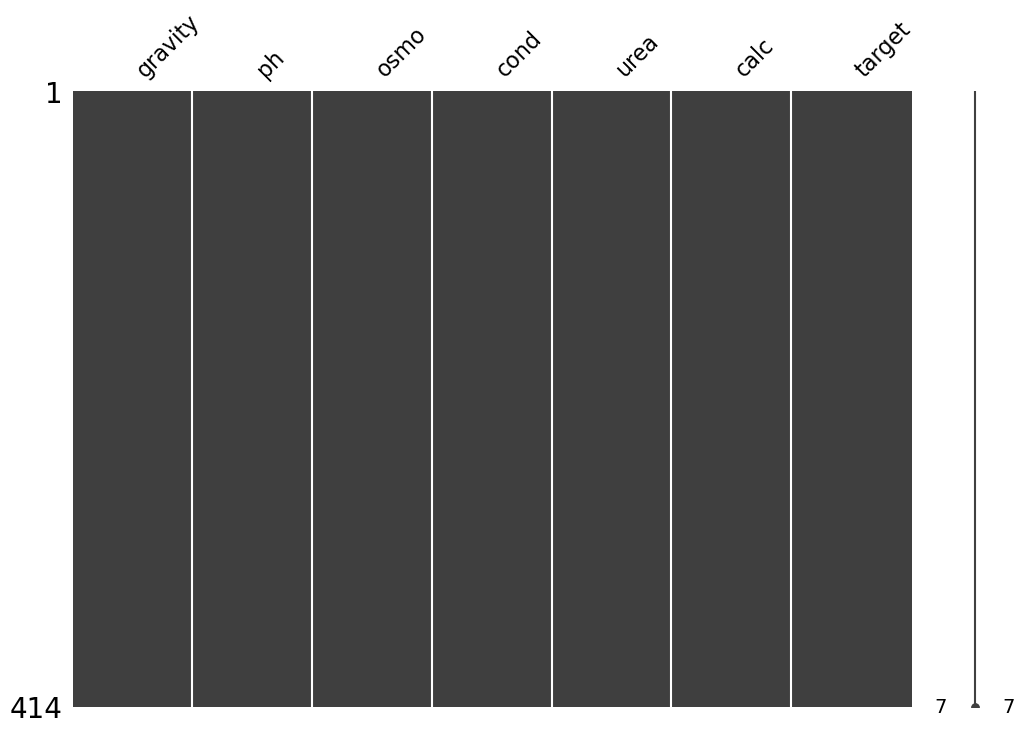

In [7]:
msno.matrix(df, figsize=(12,8), )

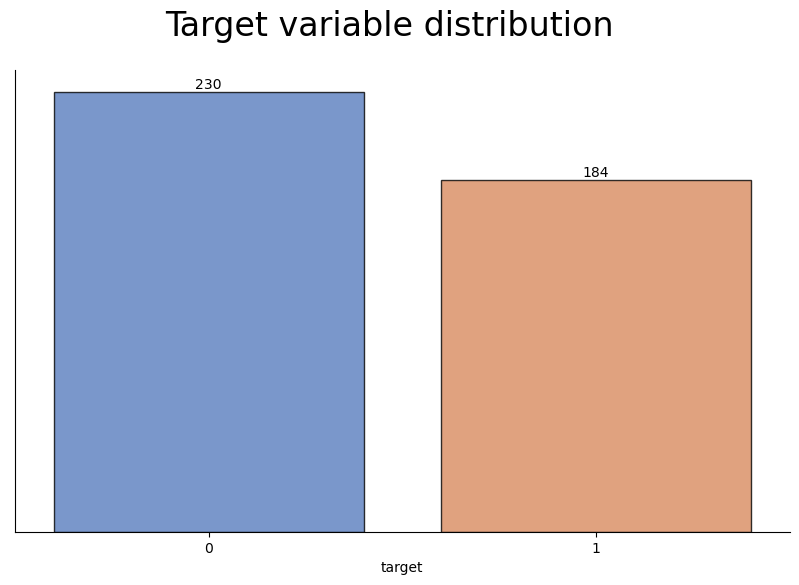

In [8]:
fig = plt.figure(figsize = (10,6))

ax = sns.countplot(x = df['target'], linewidth = 1, edgecolor = 'black', alpha = .8)
for i in ax.containers:
    ax.bar_label(i,)

fig.suptitle('Target variable distribution\n', fontsize = 24)

ax.set_ylabel('')

plt.yticks([])
sns.despine()
plt.show()

### Findings

- The number of available samples is very low
- All the features are numeric
- The target is binary 0 - 1
- The target is unbalanced
- There are no missing values

In [9]:
def oversample_minority_class(df, target_col):
    """Oversamples the minority class in a given DataFrame based on a target column."""
    
    # Determine the value counts of the target column
    target_counts = df[target_col].value_counts()
    
    # Find the minority and majority classes
    minority_class = target_counts.idxmin()
    majority_class = target_counts.idxmax()
    
    diff = target_counts[majority_class] - target_counts[minority_class]
    
    if diff == 0:
        return df
    
    minority_df = df[df[target_col] == minority_class]
    
    replacement = False
    if len(minority_df) < diff:
        replacement = True
        
    balanced_df = pd.concat([df, minority_df.sample(n = diff, replace = replacement)])
    
    return balanced_df

## Exploring and transforming the data

### Oversampling to balance the target variable

In [10]:
df = oversample_minority_class(df, 'target')

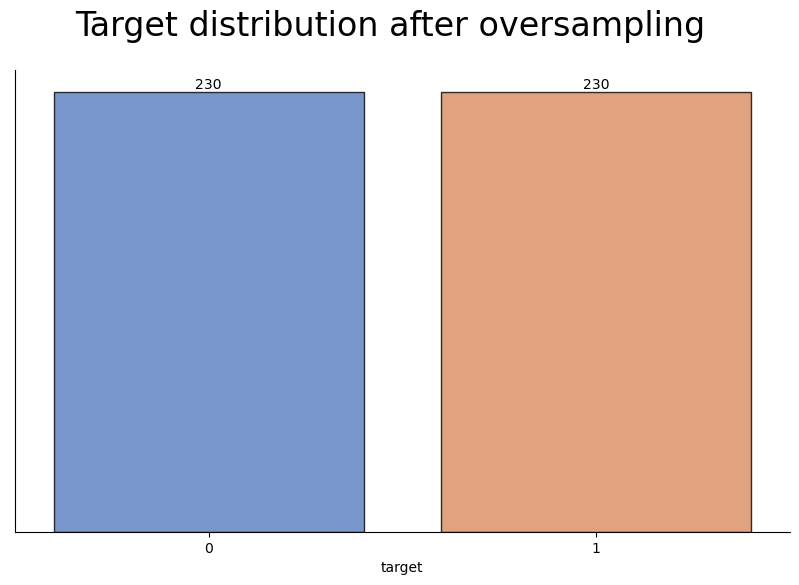

In [11]:
fig = plt.figure(figsize = (10,6))

ax = sns.countplot(x = df['target'], linewidth = 1, edgecolor = 'black', alpha = .8)
for i in ax.containers:
    ax.bar_label(i,)

fig.suptitle('Target distribution after oversampling\n', fontsize = 24)

ax.set_ylabel('')

plt.yticks([])
sns.despine()
plt.show()

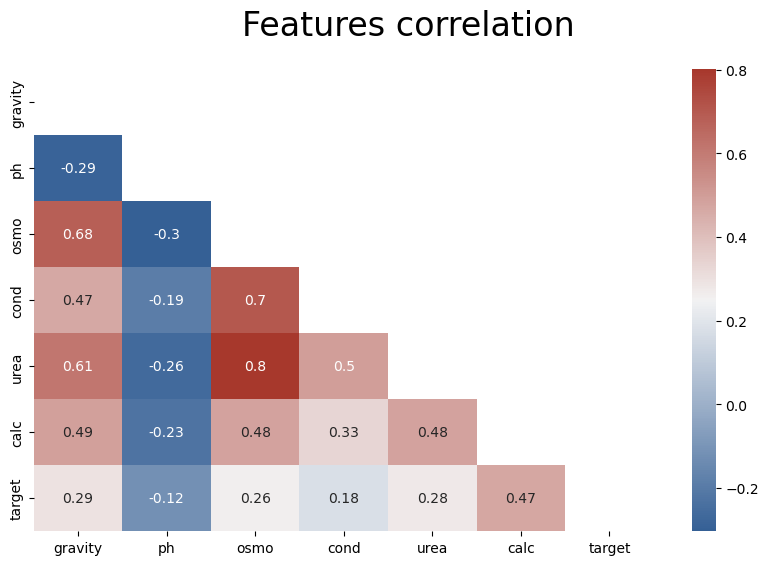

In [12]:
fig = plt.figure(figsize = (10,6))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, as_cmap=True)
ax = sns.heatmap(df.corr(), annot=True, mask=mask, cmap = cmap)
fig.suptitle('Features correlation\n', fontsize = 24)
plt.show()

- The correlations are not very promising
- Calc has a good correlation with the target
- The other features are correlated to each other especially osmo

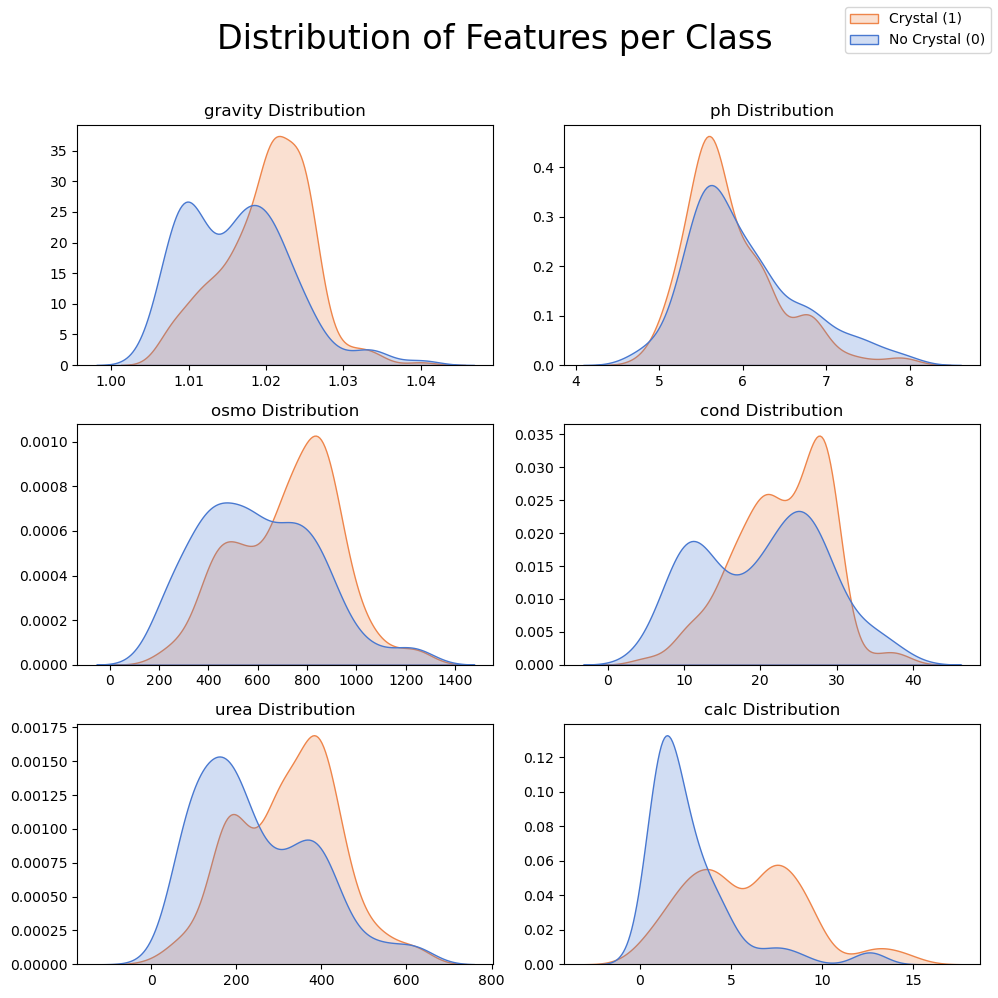

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
ax = ax.flatten()

for i, col in enumerate(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']):
    sns.kdeplot(data = df, x = col, ax=ax[i], fill = True, legend = False, 
                hue = 'target')
    
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24)
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()
plt.show()

- Its is possible to observe that for each variable there are certain threshoulds where the class probability shifts.
- Calc is the most promising feature
- PH seems be useless from a univariant point of view
- The other variables may be useful
- We made a dummy predictor using only calc to estimate the target, the predictor got a score of .83 in the test set.


## KMEANS clustering

Unfortunately we only have a few samples available and so we need to be careful when selection the amount of training features:

If we selected so many variables we will fall into the curse of dimensionality which is caused by the relative lack of samples in comparison the amount of features.

We choose to train our model with only features, one will calc and we'll create another categorical variable by clustering the remaining features.

The idea behinde clustering is to understand and capture multivariant behaviors into a single 'cluster' variable.

We choose to leave 'calc' out of the clustering in order to avoid redundancy.

In [14]:
cluster_cols = ['gravity', 'ph', 'osmo', 'cond', 'urea']

scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df[cluster_cols])
df_norm = pd.DataFrame(df_norm, columns=cluster_cols)
test_norm = scaler.transform(test[cluster_cols])
test_norm = pd.DataFrame(test_norm, columns=cluster_cols)

kmeans = KMeans(n_clusters=3, random_state=0)
df_norm['cluster'] = kmeans.fit_predict(df_norm)
df['cluster'] = df_norm['cluster']

test['cluster'] = kmeans.predict(test_norm)

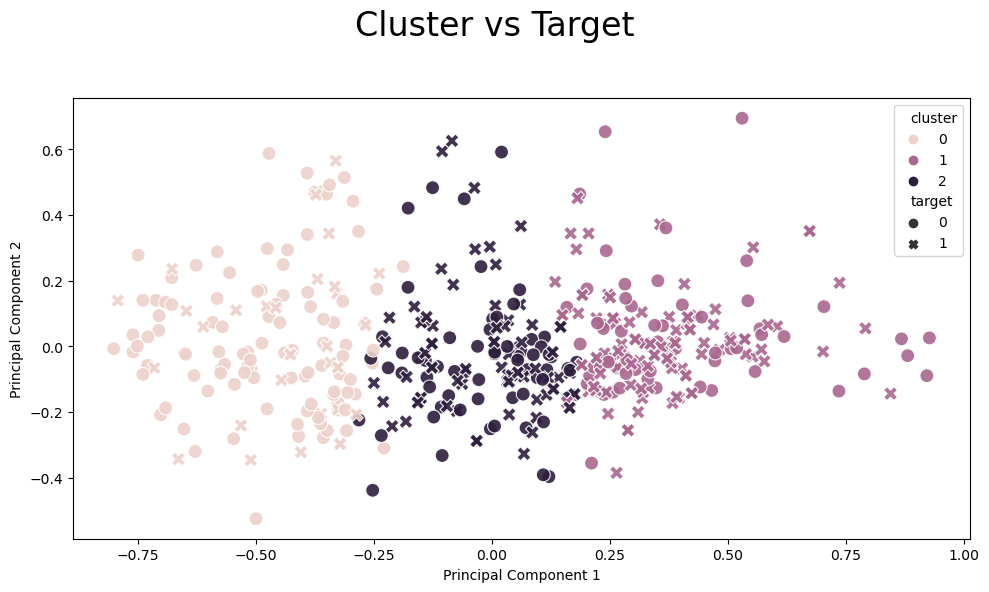

In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_norm[cluster_cols])

fig = plt.figure(figsize = (10, 6))
ax = sns.scatterplot(x = principal_components[:, 0],y= principal_components[:, 1], hue=df['cluster'], style=df['target'], s = 100,
               alpha = 0.9)

fig.suptitle('Cluster vs Target\n', fontsize = 24)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [16]:
cluster_probs = df.groupby('cluster').agg(prob = ('target', 'mean'))
centroids = pd.DataFrame(columns = ['gravity', 'ph', 'osmo', 'cond', 'urea'],
                        data = scaler.inverse_transform(kmeans.cluster_centers_))
cluster_info = pd.concat([cluster_probs, centroids], axis = 1)
cluster_info.index.name = 'cluster'
cluster_info

,prob,gravity,ph,osmo,cond,urea
cluster,,,,,,
0,0.255474,1.011781,6.318832,400.583942,13.974453,144.124088
1,0.648045,1.023134,5.746425,879.849162,26.796648,410.379888
2,0.548611,1.017993,5.803681,634.937500,22.327778,259.020833


In [17]:
df['kmeans_feature'] = df['cluster'].replace(cluster_probs.to_dict()['prob']) + np.random.normal(loc = 0, scale = 0.05, size = len(df))
test['kmeans_feature'] = test['cluster'].replace(cluster_probs.to_dict()['prob']) + np.random.normal(loc = 0, scale = 0.05, size = len(test))

 I did my best to make this graph readble so we can get some insights from the clusters:
- When the features (except for ph) have low values the target is more likely to be 0 (about 75% prob)
- When the values are close to the middle of the range the positive target change slightly increases (65%)
- When the values are high the probabilty is approximately equal for both classes.
We created two new features out of the clustering model:
- cluster: a categorical variable representing the cluster label
- kmeans_feature: a numerical variable that defined by the sum of the class 1 probability for the respective cluster + some white noise.

We avoided using techniques like one hot encoding because as mentioned before, we decide not to increase the dimensionality of the data.


## Modeling

We have evaluate the CatBoostClassifier within three different feature combinations:
- calc + kmenas_feature
- calc + cond
- calc + cluster(using the cat_feature resource of the model)

In [18]:
def evaluate_model(model, X, y, cat_features = []):
    # Define the cross-validation method
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=100, random_state = seed)

    # Define the metric to optimize
    scoring = 'roc_auc'
    
    if len(cat_features) > 0:
        # Evaluate the model using cross-validation
        scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, 
                                 fit_params = {'cat_features': cat_features})
    else:
        scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # Calculate the mean and standard deviation of the scores
    mean_score, std_score = np.mean(scores), np.std(scores)

    # Print the mean and standard deviation of the scores
    print(f'Mean ROC AUC: {mean_score:.3f} (std: {std_score:.3f})')

In [19]:
evaluate_model(model = CatBoostClassifier(random_state=seed, verbose = 0),
              X = df[['calc', 'kmeans_feature']],
              y = df['target'])

Mean ROC AUC: 0.807 (std: 0.036)


In [20]:
evaluate_model(model = CatBoostClassifier(random_state=seed, verbose = 0),
              X = df[['calc', 'cond']],
              y = df['target'])

Mean ROC AUC: 0.803 (std: 0.038)


In [21]:
evaluate_model(model = CatBoostClassifier(random_state=seed, verbose = 0),
              X = df[['calc', 'cluster']],
              y = df['target'],
              cat_features = ['cluster'])

Mean ROC AUC: 0.809 (std: 0.038)


We managed to score about .81 on using calc+cond and calc+cluster.

**The test score was .858.**

We tried to tune the model but it appear that the default CatBoost parameters are more apropriated.

## Submission

In [22]:
model = CatBoostClassifier(random_state=seed, verbose = 0)
model.fit(df[['calc', 'cluster']], df['target'], 
             cat_features = ['cluster'])
sample_submission['target'] = model.predict_proba(test[['calc', 'cluster']])[:,1]
sample_submission.to_csv('submission.csv', index=False)

## Dummy submission (public roc = .83)

This is the baseline dummy we mentioned before. We used it as the basline result.


In [23]:
target = (test['calc'] >= 4).astype(int)
sample_submission['target'] = target

In [24]:
#sample_submission.to_csv('submission.csv', index=False)

## Conclusion and next steps

The challenge is very interesting as it force us to handle small datasets and learn how to avoid overfitting.

We will try other classification approches in order to earn more knowledge about how to deal with this kind of problem